# Feature Selection

Choosing the most effective variables



In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt
import os
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn import ensemble, tree, linear_model
from sklearn import tree
from sklearn.metrics import accuracy_score
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import KNNImputer
from scipy.stats import pearsonr

plt.style.use('seaborn')
import re
from scipy import stats
from scipy.stats import chisquare
from scipy.stats import chi2_contingency
from scipy.stats import f_oneway
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import ks_2samp
from scipy.stats import norm
import missingno as msno
import datetime
import pickle

In [2]:
# load dataframes
with open("../pickles/df_after_feature_engineering.pkl", "rb") as f:
    df = pickle.load(f)

In [3]:
df.head()

,gameID,leagueID,season,date,homeTeamID,awayTeamID,home_Goals,away_Goals,home_GoalsHalfTime,away_GoalsHalfTime,...,recent_form_diff,interaction_goal_rate_vs_blocks,interaction_goal_rate_vs_conceded,interaction_xG_efficiency_vs_shots_conceded,rolling_xG_vs_shot_conceded,rolling_shot_rate_vs_blocks,discipline_matchup_score,interaction_away_goal_rate_vs_home_def,interaction_away_form_vs_home_cards,form_vs_discipline_gap
5437,6185,5,2014,2014-08-08 19:30:00,177,161,2,2,2,1,...,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000
5438,6186,5,2014,2014-08-09 20:00:00,162,164,3,3,1,2,...,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.392846,0.047790,-0.028571
5439,6187,5,2014,2014-08-09 20:00:00,209,165,0,3,0,3,...,0.0,1.713977,9523.809524,174392.090970,0.0,0.0,0.006144,1.499865,0.070921,-0.035714
5440,6188,5,2014,2014-08-09 20:00:00,169,175,0,2,0,1,...,0.0,1.259045,0.074073,1.113665,0.0,0.0,0.004831,0.473663,0.066536,-0.031189
5441,6189,5,2014,2014-08-09 20:00:00,160,180,0,0,0,0,...,0.0,0.227264,0.040404,0.536304,0.0,0.0,0.003565,0.760592,0.068226,-0.002229


In [4]:
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12680 entries, 5437 to 12679
Data columns (total 107 columns):
 #    Column                                       Dtype         
---   ------                                       -----         
 0    gameID                                       int64         
 1    leagueID                                     int64         
 2    season                                       int64         
 3    date                                         datetime64[ns]
 4    homeTeamID                                   int64         
 5    awayTeamID                                   int64         
 6    home_Goals                                   int64         
 7    away_Goals                                   int64         
 8    home_GoalsHalfTime                           int64         
 9    away_GoalsHalfTime                           int64         
 10   home_xGoals                                  float64       
 11   home_shots             

lets droop columns that are high related with the target value and columns that are unnecesary (like date, duplicates...)

In [5]:
cols_to_drop = ['home_Goals','away_Goals','home_GoalsHalfTime','away_GoalsHalfTime','date',
                'home_yellowCards', 'home_redCards','away_yellowCards', 'away_redCards','home_total_yellow_cards',
               'home_total_yellow_cards','away_total_red_cards','home_total_red_cards','away_shotsOnTarget',
               'home_total_assists','away_total_assists','home_corners','away_corners','home_Goals_cat','away_Goals_cat',
               'home_total_blocked_shots','away_total_blocked_shots','home_total_saved_shots','away_total_saved_shots',
               'gameID','homeTeamID','awayTeamID','home_total_assists_cat','away_total_assists_cat']

In [6]:
df = df.drop(columns=cols_to_drop)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12680 entries, 5437 to 12679
Data columns (total 79 columns):
 #   Column                                       Non-Null Count  Dtype   
---  ------                                       --------------  -----   
 0   leagueID                                     12680 non-null  int64   
 1   season                                       12680 non-null  int64   
 2   home_xGoals                                  12680 non-null  float64 
 3   home_shots                                   12680 non-null  float64 
 4   home_shotsOnTarget                           12680 non-null  int64   
 5   home_deep                                    12680 non-null  float64 
 6   home_ppda                                    12680 non-null  float64 
 7   home_fouls                                   12680 non-null  float64 
 8   home_total_xAssists                          12680 non-null  float64 
 9   home_total_key_passes                        12680 non-nul

In [8]:
#Creating Variables dataframes
varSel = pd.DataFrame({'Variable': df.columns.drop('gameresult')})
varSel

,Variable
0,leagueID
1,season
2,home_xGoals
3,home_shots
4,home_shotsOnTarget
...,...
73,rolling_shot_rate_vs_blocks
74,discipline_matchup_score
75,interaction_away_goal_rate_vs_home_def
76,interaction_away_form_vs_home_cards


## Univariable Analysis

In [9]:
#from importlib import reload
from pyMechkar.analysis import Table1
#reload(tb1)

In [10]:
nm = df.columns.drop('gameresult')
nm = nm.append(pd.Index(['gameresult']))
nm

Index(['leagueID', 'season', 'home_xGoals', 'home_shots', 'home_shotsOnTarget',
       'home_deep', 'home_ppda', 'home_fouls', 'home_total_xAssists',
       'home_total_key_passes', 'home_total_xGoalsChain',
       'home_total_xGoalsBuildup', 'away_xGoals', 'away_shots', 'away_deep',
       'away_ppda', 'away_fouls', 'away_total_xAssists',
       'away_total_key_passes', 'away_total_xGoalsChain',
       'away_total_xGoalsBuildup', 'away_total_yellow_cards',
       'home_redCards_binary', 'away_redCards_binary', 'home_yellowCards_cat',
       'away_yellowCards_cat', 'home_shotsOnTarget_cat',
       'away_shotsOnTarget_cat', 'home_corners_cat', 'away_corners_cat',
       'home_total_blocked_shots_cat', 'away_total_blocked_shots_cat',
       'home_total_saved_shots_cat', 'away_total_saved_shots_cat', 'year',
       'month', 'day', 'time_category', 'is_weekend',
       'home_cumulative_goals_for', 'away_cumulative_goals_for',
       'home_cumulative_goals_against', 'away_cumulative_goals_a

In [11]:
df2 = df[nm].copy()
df2.head()

,leagueID,season,home_xGoals,home_shots,home_shotsOnTarget,home_deep,home_ppda,home_fouls,home_total_xAssists,home_total_key_passes,...,interaction_goal_rate_vs_blocks,interaction_goal_rate_vs_conceded,interaction_xG_efficiency_vs_shots_conceded,rolling_xG_vs_shot_conceded,rolling_shot_rate_vs_blocks,discipline_matchup_score,interaction_away_goal_rate_vs_home_def,interaction_away_form_vs_home_cards,form_vs_discipline_gap,gameresult
5437,5,2014,1.367870,9.0,3,2.0,31.6000,15.000000,1.283730,7.0,...,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,1
5438,5,2014,1.396890,14.0,4,2.0,5.7429,12.597074,0.232187,6.0,...,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.392846,0.047790,-0.028571,1
5439,5,2014,0.813737,9.0,2,3.0,7.0000,12.000000,0.739955,8.0,...,1.713977,9523.809524,174392.090970,0.0,0.0,0.006144,1.499865,0.070921,-0.035714,0
5440,5,2014,0.632940,6.0,3,3.0,16.0625,9.000000,0.562167,3.0,...,1.259045,0.074073,1.113665,0.0,0.0,0.004831,0.473663,0.066536,-0.031189,0
5441,5,2014,1.544680,14.0,3,5.0,3.6087,9.000000,0.897067,8.0,...,0.227264,0.040404,0.536304,0.0,0.0,0.003565,0.760592,0.068226,-0.002229,1


In [12]:
tab1 = Table1(data=df2, y="gameresult")

Begining analysis...
Factorizing... please wait
******************************************************************************
[]
*******************************************************************************
*******************************************************************************
*******************************************************************************
[]
------ Finished in 38.42795181274414econds -----


In [13]:
from IPython.display import display
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

display(tab1)


,Variables,Categories,Population,Category_1,Category_0,Category_2,p_value
0,Individuals,n,12680,3172,3854,5654,NaN
1,leagueID,1,"2,660.00 ( 21.00%)",629.00 ( 19.80%),845.00 ( 21.90%),"1,186.00 ( 21.00%)",NaN
2,leagueID,2,"2,660.00 ( 21.00%)",668.00 ( 21.10%),837.00 ( 21.70%),"1,155.00 ( 20.40%)",0.247
3,leagueID,4,"2,660.00 ( 21.00%)",682.00 ( 21.50%),764.00 ( 19.80%),"1,214.00 ( 21.50%)",NaN
4,leagueID,5,"2,558.00 ( 20.20%)",661.00 ( 20.80%),757.00 ( 19.60%),"1,140.00 ( 20.20%)",NaN
5,leagueID,3,"2,142.00 ( 16.90%)",532.00 ( 16.80%),651.00 ( 16.90%),959.00 ( 17.00%),NaN
6,season,Mean (SD),"2,017.00 ( 2.00)","2,017.00 ( 2.00)","2,017.10 ( 2.00)","2,016.90 ( 2.00)",0.000
7,season,Median (IQR),"2,017.00 (2,015.00-2,019.00)","2,017.00 (2,015.00-2,019.00)","2,017.00 (2,015.00-2,019.00)","2,017.00 (2,015.00-2,019.00)",NaN
9,home_xGoals,Mean (SD),1.40 ( 0.80),1.30 ( 0.70),1.00 ( 0.60),1.80 ( 0.80),0.000
10,home_xGoals,Median (IQR),1.30 ( 0.80- 1.90),1.20 ( 0.80- 1.70),0.90 ( 0.60- 1.40),1.70 ( 1.30- 2.30),NaN


In [14]:
tab1[tab1['p_value']<0.05]

,Variables,Categories,Population,Category_1,Category_0,Category_2,p_value
6,season,Mean (SD),"2,017.00 ( 2.00)","2,017.00 ( 2.00)","2,017.10 ( 2.00)","2,016.90 ( 2.00)",0.000
9,home_xGoals,Mean (SD),1.40 ( 0.80),1.30 ( 0.70),1.00 ( 0.60),1.80 ( 0.80),0.000
12,home_shots,Mean (SD),13.50 ( 4.90),13.20 ( 4.90),12.30 ( 4.80),14.40 ( 4.80),0.000
15,home_shotsOnTarget,Mean (SD),4.70 ( 2.60),4.10 ( 2.20),3.50 ( 2.10),5.90 ( 2.60),0.000
18,home_deep,Mean (SD),6.10 ( 3.70),5.90 ( 3.60),5.40 ( 3.40),6.80 ( 3.80),0.000
21,home_ppda,Mean (SD),10.50 ( 5.60),10.10 ( 5.40),11.30 ( 6.70),10.20 ( 4.80),0.000
24,home_fouls,Mean (SD),12.60 ( 3.80),12.90 ( 3.80),12.70 ( 3.80),12.40 ( 3.90),0.000
27,home_total_xAssists,Mean (SD),1.00 ( 0.60),0.90 ( 0.50),0.70 ( 0.50),1.20 ( 0.60),0.000
30,home_total_key_passes,Mean (SD),10.00 ( 4.10),9.70 ( 4.10),9.00 ( 3.90),10.90 ( 4.10),0.000
33,home_total_xGoalsChain,Mean (SD),4.00 ( 3.30),3.30 ( 2.40),2.50 ( 2.00),5.40 ( 3.80),0.000


In [15]:

# Reset to default
pd.reset_option('display.max_rows')
pd.reset_option('display.max_columns')

In [16]:
vn1 = tab1.loc[tab1['p_value']<0.05,'Variables'].unique()
print(len(vn1))
vn1

35


array(['season', 'home_xGoals', 'home_shots', 'home_shotsOnTarget',
       'home_deep', 'home_ppda', 'home_fouls', 'home_total_xAssists',
       'home_total_key_passes', 'home_total_xGoalsChain',
       'home_total_xGoalsBuildup', 'away_xGoals', 'away_shots',
       'away_deep', 'away_ppda', 'away_fouls', 'away_total_xAssists',
       'away_total_key_passes', 'away_total_xGoalsChain',
       'away_total_xGoalsBuildup', 'away_total_yellow_cards',
       'home_redCards_binary', 'away_redCards_binary',
       'home_yellowCards_cat', 'away_yellowCards_cat',
       'home_shotsOnTarget_cat', 'away_shotsOnTarget_cat',
       'home_corners_cat', 'home_total_blocked_shots_cat',
       'home_total_saved_shots_cat', 'away_total_saved_shots_cat', 'year',
       'time_category', 'home_discipline_score_avg',
       'away_discipline_score_avg'], dtype=object)

We will add these variables to our variable selection table

In [17]:
varSel['Univarable'] = 0
varSel.loc[varSel['Variable'].isin(vn1), 'Univarable'] = 1
varSel

,Variable,Univarable
0,leagueID,0
1,season,1
2,home_xGoals,1
3,home_shots,1
4,home_shotsOnTarget,1
...,...,...
73,rolling_shot_rate_vs_blocks,0
74,discipline_matchup_score,0
75,interaction_away_goal_rate_vs_home_def,0
76,interaction_away_form_vs_home_cards,0


# Multivariable Analysis

In [18]:
### drop na
df2 = df2.dropna()

In [19]:
# remove unnecessary vars (in this case the target variable)
X = df2.iloc[:,:-1]
X

,leagueID,season,home_xGoals,home_shots,home_shotsOnTarget,home_deep,home_ppda,home_fouls,home_total_xAssists,home_total_key_passes,...,recent_form_diff,interaction_goal_rate_vs_blocks,interaction_goal_rate_vs_conceded,interaction_xG_efficiency_vs_shots_conceded,rolling_xG_vs_shot_conceded,rolling_shot_rate_vs_blocks,discipline_matchup_score,interaction_away_goal_rate_vs_home_def,interaction_away_form_vs_home_cards,form_vs_discipline_gap
5437,5,2014,1.367870,9.0,3,2.0,31.6000,15.000000,1.283730,7.0,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5438,5,2014,1.396890,14.0,4,2.0,5.7429,12.597074,0.232187,6.0,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.392846,0.047790,-0.028571
5439,5,2014,0.813737,9.0,2,3.0,7.0000,12.000000,0.739955,8.0,...,0.0,1.713977,9523.809524,174392.090970,0.000000,0.000000,0.006144,1.499865,0.070921,-0.035714
5440,5,2014,0.632940,6.0,3,3.0,16.0625,9.000000,0.562167,3.0,...,0.0,1.259045,0.074073,1.113665,0.000000,0.000000,0.004831,0.473663,0.066536,-0.031189
5441,5,2014,1.544680,14.0,3,5.0,3.6087,9.000000,0.897067,8.0,...,0.0,0.227264,0.040404,0.536304,0.000000,0.000000,0.003565,0.760592,0.068226,-0.002229
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12675,5,2020,1.411190,15.0,5,17.0,12.3684,8.000000,0.971853,11.0,...,2.0,0.709173,0.055504,0.689314,5.982849,0.833278,0.005526,0.366958,0.062061,0.002703
12676,5,2020,1.198190,10.0,3,3.0,16.2632,11.000000,0.855524,8.0,...,-1.0,0.305544,0.045139,0.538391,1.407168,0.271595,0.004440,0.051354,0.062261,-0.002233
12677,5,2020,1.332690,12.0,6,10.0,8.2857,11.000000,1.151649,8.0,...,-5.0,0.262458,0.045931,0.563541,0.914720,0.064100,0.004306,0.859289,0.057900,-0.002056
12678,5,2020,1.460500,19.0,5,6.0,7.5600,13.000000,1.265829,13.0,...,-1.0,0.785636,0.040640,0.485981,0.356758,0.175421,0.004414,0.401440,0.054791,-0.000600


In [20]:
y = df2.iloc[:,-1:]
print([X.shape,y.shape])

[(12680, 78), (12680, 1)]


## Variable Selection using LASSO (L1 penalization)

In [21]:
from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler


In [22]:
# Step 0: X = full feature dataframe, y = target
X_encoded = X.copy()

# Step 1: Encode categorical columns using .cat.codes
for col in X_encoded.select_dtypes(include=['category', 'object']).columns:
    X_encoded[col] = X_encoded[col].astype('category').cat.codes

# Step 2: Drop datetime columns if still present
X_encoded = X_encoded.drop(columns=[
    col for col in X_encoded.columns 
    if np.issubdtype(X_encoded[col].dtype, np.datetime64)
], errors='ignore')

# Step 3: Handle missing values
X_encoded = X_encoded.dropna()  # or use .fillna(method='ffill') or .fillna(0)

# Step 4: Align y
y_clean = y.loc[X_encoded.index]

# Step 5: Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_encoded)


In [23]:
X = X_scaled
y = y_clean

In [24]:
lassomod = Lasso(alpha=0.01).fit(X, y)

In [25]:
model = SelectFromModel(lassomod, prefit=True)
model.get_support()

array([False, False,  True,  True,  True, False,  True, False,  True,
       False, False, False,  True, False, False,  True, False,  True,
       False,  True, False, False,  True,  True,  True, False,  True,
        True, False,  True,  True,  True,  True,  True, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False,  True, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False])

In [26]:
print("Features in varSel but not in model:")
print(set(varSel['Variable']) - set(X_encoded.columns))

print("Features in model but not in varSel:")
print(set(X_encoded.columns) - set(varSel['Variable']))


Features in varSel but not in model:
set()
Features in model but not in varSel:
set()


In [27]:
X_model_input = X_encoded.copy()  # after cleaning, encoding, dropping nulls


In [28]:
# Re-train Lasso using the correct input
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_model_input)

from sklearn.linear_model import Lasso
lasso = Lasso(alpha=0.01)
lasso.fit(X_scaled, y_clean)


Lasso(alpha=0.01)

In [29]:
selected_features = X_model_input.columns[lasso.coef_ != 0]
varSel['Lasso'] = varSel['Variable'].isin(selected_features).astype(int)


In [30]:
selected_features = X_model_input.columns[model.get_support()]


In [31]:
varSel['Lasso'] = varSel['Variable'].isin(selected_features).astype('int64')


In [32]:
varSel[varSel['Lasso'] == 1]


,Variable,Univarable,Lasso
2,home_xGoals,1,1
3,home_shots,1,1
4,home_shotsOnTarget,1,1
6,home_ppda,1,1
8,home_total_xAssists,1,1
12,away_xGoals,1,1
15,away_ppda,1,1
17,away_total_xAssists,1,1
19,away_total_xGoalsChain,1,1
22,home_redCards_binary,1,1


In [33]:
varSel['Lasso'].sum()


21

In [34]:
varSel[(varSel['Lasso'] == 1) & (varSel['Univarable'] == 1)]


,Variable,Univarable,Lasso
2,home_xGoals,1,1
3,home_shots,1,1
4,home_shotsOnTarget,1,1
6,home_ppda,1,1
8,home_total_xAssists,1,1
12,away_xGoals,1,1
15,away_ppda,1,1
17,away_total_xAssists,1,1
19,away_total_xGoalsChain,1,1
22,home_redCards_binary,1,1


In [35]:
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Lasso

# Step 1: Create Lasso and wrap it in SelectFromModel
lasso_base = Lasso(alpha=0.01)
model = SelectFromModel(estimator=lasso_base)

# Step 2: Fit the SelectFromModel on your scaled features
model.fit(X_scaled, y_clean)

# Step 3: Now safely access the fitted Lasso
lasso_model = model.estimator_

# Step 4: Get the Lasso coefficients
lasso_result = pd.Series(lasso_model.coef_, index=X_model_input.columns)
lasso_selected = lasso_result[lasso_result != 0].sort_values(key=abs, ascending=False)
lasso_selected


home_shotsOnTarget              0.631688
home_total_saved_shots_cat     -0.526434
away_shotsOnTarget_cat         -0.261366
away_xGoals                    -0.217485
away_total_saved_shots_cat      0.213248
home_shotsOnTarget_cat          0.090812
home_xGoals                     0.078230
away_total_xGoalsChain         -0.064152
away_total_blocked_shots_cat    0.056437
home_total_xAssists             0.041181
home_total_blocked_shots_cat   -0.038215
home_shots                     -0.033069
away_ppda                      -0.023720
away_redCards_binary            0.023501
home_redCards_binary           -0.023260
away_corners_cat                0.017397
away_total_xAssists            -0.014101
home_ppda                       0.009545
away_discipline_score_avg      -0.001796
away_blocked_shot_ratio         0.000102
home_yellowCards_cat           -0.000095
dtype: float64

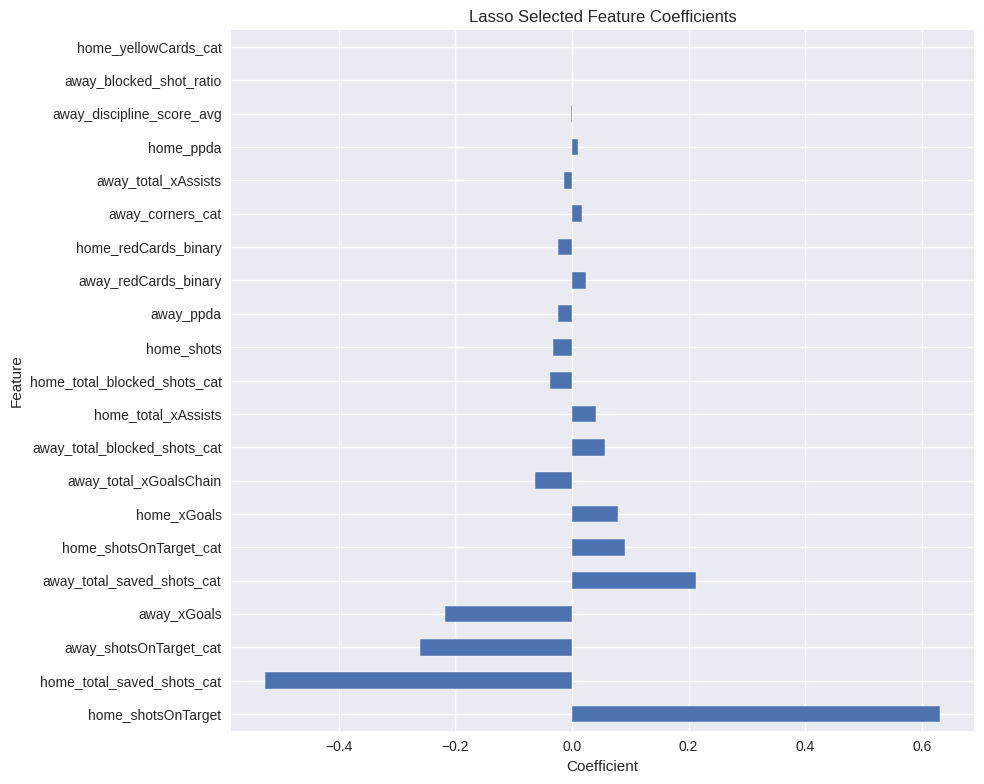

In [36]:
lasso_selected.plot(kind='barh', figsize=(10, 8))
plt.title("Lasso Selected Feature Coefficients")
plt.xlabel("Coefficient")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

## Variable Selection using Random Forest

In [37]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel

rfmod = RandomForestClassifier().fit(X_scaled, y_clean)
#rfmod.feature_importances_ 

In [38]:
model = SelectFromModel(rfmod, prefit=True)
model.get_support()

array([False, False,  True, False,  True, False,  True, False,  True,
       False,  True,  True,  True, False, False,  True, False,  True,
       False,  True,  True, False, False, False, False, False,  True,
        True, False, False, False, False,  True, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False])

In [39]:
selected_rf_features = X_model_input.columns[model.get_support()]


In [40]:
varSel['RandomForest'] = varSel['Variable'].isin(selected_rf_features).astype('int64')


In [41]:
varSel[varSel['RandomForest'] == 1]


,Variable,Univarable,Lasso,RandomForest
2,home_xGoals,1,1,1
4,home_shotsOnTarget,1,1,1
6,home_ppda,1,1,1
8,home_total_xAssists,1,1,1
10,home_total_xGoalsChain,1,0,1
11,home_total_xGoalsBuildup,1,0,1
12,away_xGoals,1,1,1
15,away_ppda,1,1,1
17,away_total_xAssists,1,1,1
19,away_total_xGoalsChain,1,1,1


In [42]:
varSel['RandomForest'].sum()


14

In [43]:
# Intersection with Lasso
display(varSel[(varSel['RandomForest'] == 1) & (varSel['Lasso'] == 1)])

# Triple intersection: RF + Lasso + Univariate
display(varSel[(varSel['RandomForest'] == 1) & (varSel['Lasso'] == 1) & (varSel['Univarable'] == 1)])


,Variable,Univarable,Lasso,RandomForest
2,home_xGoals,1,1,1
4,home_shotsOnTarget,1,1,1
6,home_ppda,1,1,1
8,home_total_xAssists,1,1,1
12,away_xGoals,1,1,1
15,away_ppda,1,1,1
17,away_total_xAssists,1,1,1
19,away_total_xGoalsChain,1,1,1
26,home_shotsOnTarget_cat,1,1,1
27,away_shotsOnTarget_cat,1,1,1


,Variable,Univarable,Lasso,RandomForest
2,home_xGoals,1,1,1
4,home_shotsOnTarget,1,1,1
6,home_ppda,1,1,1
8,home_total_xAssists,1,1,1
12,away_xGoals,1,1,1
15,away_ppda,1,1,1
17,away_total_xAssists,1,1,1
19,away_total_xGoalsChain,1,1,1
26,home_shotsOnTarget_cat,1,1,1
27,away_shotsOnTarget_cat,1,1,1


In [44]:
rf = RandomForestClassifier(random_state=42)
model = SelectFromModel(estimator=rf)
model.fit(X_scaled, y_clean)

SelectFromModel(estimator=RandomForestClassifier(random_state=42))

In [45]:
importances = pd.Series(model.estimator_.feature_importances_, index=X_model_input.columns)
importances = importances[importances != 0].sort_values(ascending=False)
importances.head(20)


home_xGoals                               0.049165
away_xGoals                               0.046881
away_total_xAssists                       0.040403
home_total_xGoalsChain                    0.036398
away_total_xGoalsChain                    0.035462
home_total_xAssists                       0.031595
home_shotsOnTarget                        0.027714
away_shotsOnTarget_cat                    0.024801
away_total_xGoalsBuildup                  0.024022
home_total_xGoalsBuildup                  0.022872
home_total_saved_shots_cat                0.018409
home_shotsOnTarget_cat                    0.017693
home_ppda                                 0.017096
away_ppda                                 0.015737
away_total_saved_shots_cat                0.012632
interaction_away_goal_rate_vs_home_def    0.012457
form_vs_discipline_gap                    0.011839
interaction_goal_rate_vs_blocks           0.011782
away_discipline_score_avg                 0.011662
away_rolling_goal_per_xg       

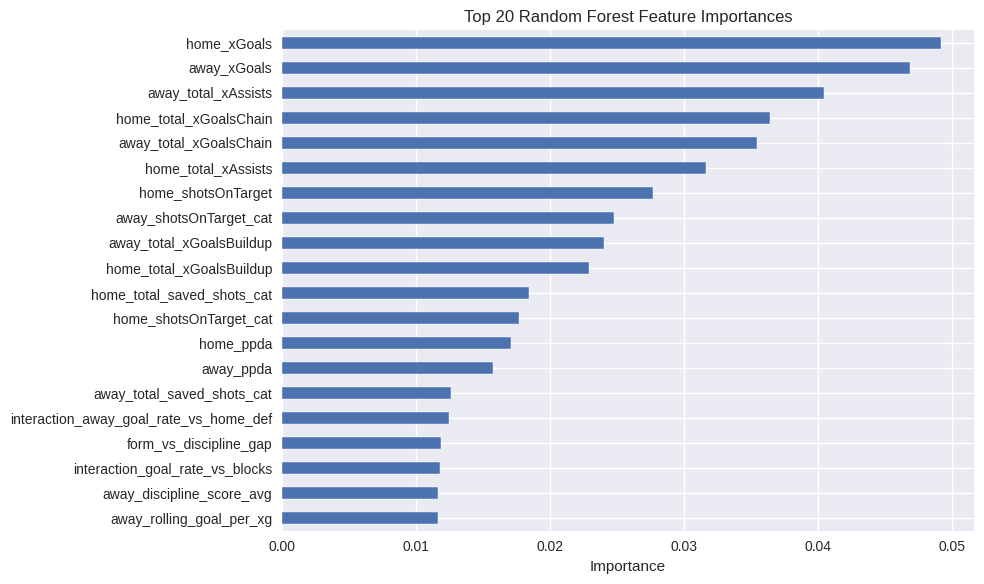

In [46]:
importances.head(20).plot(kind='barh', figsize=(10, 6))
plt.title("Top 20 Random Forest Feature Importances")
plt.xlabel("Importance")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


## Variable Selection using Gradient Boosting classification

In [47]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.feature_selection import SelectFromModel

In [48]:
gbmod = GradientBoostingClassifier().fit(X_scaled, y_clean)

In [49]:
model = SelectFromModel(gbmod, prefit=True)
model.get_support()

array([False, False,  True, False,  True, False, False, False, False,
       False,  True, False,  True, False, False, False, False,  True,
       False,  True, False, False, False, False, False, False,  True,
        True, False, False, False, False,  True,  True, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False])

In [50]:
selected_gb_features = X_model_input.columns[model.get_support()]

In [51]:
varSel['GradienBoosting'] = varSel['Variable'].isin(selected_gb_features).astype('int64')


In [52]:
varSel[varSel['GradienBoosting'] == 1]


,Variable,Univarable,Lasso,RandomForest,GradienBoosting
2,home_xGoals,1,1,1,1
4,home_shotsOnTarget,1,1,1,1
10,home_total_xGoalsChain,1,0,1,1
12,away_xGoals,1,1,1,1
17,away_total_xAssists,1,1,1,1
19,away_total_xGoalsChain,1,1,1,1
26,home_shotsOnTarget_cat,1,1,1,1
27,away_shotsOnTarget_cat,1,1,1,1
32,home_total_saved_shots_cat,1,1,1,1
33,away_total_saved_shots_cat,1,1,0,1


In [53]:
varSel['GradienBoosting'].sum()


10

In [54]:
# Lasso & GB
display(varSel[(varSel['GradienBoosting'] == 1) & (varSel['Lasso'] == 1)])

# GB & Random Forest
display(varSel[(varSel['GradienBoosting'] == 1) & (varSel['RandomForest'] == 1)])

# Lasso & RF & GB
display(varSel[(varSel['GradienBoosting'] == 1) & 
       (varSel['RandomForest'] == 1) & 
       (varSel['Lasso'] == 1)])

# All 4: GB + RF + Lasso + Univariate
display(varSel[(varSel['GradienBoosting'] == 1) &
       (varSel['RandomForest'] == 1) &
       (varSel['Lasso'] == 1) &
       (varSel['Univarable'] == 1)])


,Variable,Univarable,Lasso,RandomForest,GradienBoosting
2,home_xGoals,1,1,1,1
4,home_shotsOnTarget,1,1,1,1
12,away_xGoals,1,1,1,1
17,away_total_xAssists,1,1,1,1
19,away_total_xGoalsChain,1,1,1,1
26,home_shotsOnTarget_cat,1,1,1,1
27,away_shotsOnTarget_cat,1,1,1,1
32,home_total_saved_shots_cat,1,1,1,1
33,away_total_saved_shots_cat,1,1,0,1


,Variable,Univarable,Lasso,RandomForest,GradienBoosting
2,home_xGoals,1,1,1,1
4,home_shotsOnTarget,1,1,1,1
10,home_total_xGoalsChain,1,0,1,1
12,away_xGoals,1,1,1,1
17,away_total_xAssists,1,1,1,1
19,away_total_xGoalsChain,1,1,1,1
26,home_shotsOnTarget_cat,1,1,1,1
27,away_shotsOnTarget_cat,1,1,1,1
32,home_total_saved_shots_cat,1,1,1,1


,Variable,Univarable,Lasso,RandomForest,GradienBoosting
2,home_xGoals,1,1,1,1
4,home_shotsOnTarget,1,1,1,1
12,away_xGoals,1,1,1,1
17,away_total_xAssists,1,1,1,1
19,away_total_xGoalsChain,1,1,1,1
26,home_shotsOnTarget_cat,1,1,1,1
27,away_shotsOnTarget_cat,1,1,1,1
32,home_total_saved_shots_cat,1,1,1,1


,Variable,Univarable,Lasso,RandomForest,GradienBoosting
2,home_xGoals,1,1,1,1
4,home_shotsOnTarget,1,1,1,1
12,away_xGoals,1,1,1,1
17,away_total_xAssists,1,1,1,1
19,away_total_xGoalsChain,1,1,1,1
26,home_shotsOnTarget_cat,1,1,1,1
27,away_shotsOnTarget_cat,1,1,1,1
32,home_total_saved_shots_cat,1,1,1,1


In [55]:
gb = GradientBoostingClassifier(random_state=42)
model = SelectFromModel(estimator=gb)
model.fit(X_scaled, y_clean)

SelectFromModel(estimator=GradientBoostingClassifier(random_state=42))

In [56]:
importances = pd.Series(model.estimator_.feature_importances_, index=X_model_input.columns)
importances = importances[importances != 0].sort_values(ascending=False)
importances.head(20)

away_xGoals                     0.163036
home_shotsOnTarget              0.161507
home_xGoals                     0.143813
home_total_saved_shots_cat      0.126675
away_shotsOnTarget_cat          0.126638
away_total_saved_shots_cat      0.115608
home_shotsOnTarget_cat          0.031500
home_total_xGoalsChain          0.026744
away_total_xGoalsChain          0.025384
away_total_xAssists             0.017550
home_total_blocked_shots_cat    0.009468
home_total_xAssists             0.008167
home_ppda                       0.005961
away_total_blocked_shots_cat    0.004902
away_ppda                       0.002903
home_shots                      0.002523
away_shots                      0.001923
home_yellowCards_cat            0.001545
away_fouls                      0.001183
away_rolling_goal_per_shot      0.001041
dtype: float64

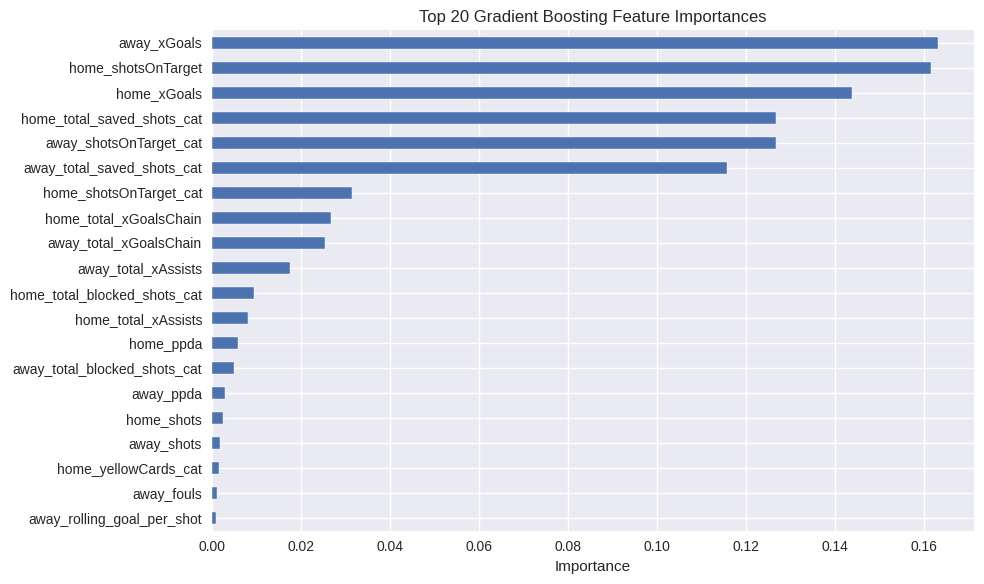

In [57]:
importances.head(20).plot(kind='barh', figsize=(10, 6))
plt.title("Top 20 Gradient Boosting Feature Importances")
plt.xlabel("Importance")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

## Variable Selection using SVM classification

In [58]:
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel

svmmod = LinearSVC(C=0.01, penalty="l1",dual=False).fit(X, y)

In [59]:
model = SelectFromModel(svmmod, prefit=True)
model.get_support()

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
       False,  True, False,  True, False,  True,  True,  True,  True,
        True,  True, False,  True,  True,  True,  True, False,  True,
        True, False,  True,  True,  True,  True,  True, False,  True,
        True,  True,  True, False, False, False, False, False,  True,
       False,  True, False,  True,  True, False, False,  True,  True,
       False, False,  True, False,  True,  True,  True,  True, False,
        True,  True, False,  True, False,  True,  True,  True, False,
        True, False, False, False,  True,  True])

In [60]:
selected_svm_features = X_model_input.columns[model.get_support()]

In [61]:
varSel['SVM'] = varSel['Variable'].isin(selected_svm_features).astype('int64')


In [62]:
varSel[varSel['SVM'] == 1]

,Variable,Univarable,Lasso,RandomForest,GradienBoosting,SVM
0,leagueID,0,0,0,0,1
1,season,1,0,0,0,1
2,home_xGoals,1,1,1,1,1
3,home_shots,1,1,0,0,1
4,home_shotsOnTarget,1,1,1,1,1
5,home_deep,1,0,0,0,1
6,home_ppda,1,1,1,0,1
7,home_fouls,1,0,0,0,1
8,home_total_xAssists,1,1,1,0,1
10,home_total_xGoalsChain,1,0,1,1,1


In [63]:
varSel['SVM'].sum()


52

In [64]:
# Get absolute value of coefficients (shape: [n_classes, n_features])
coefs = np.abs(svmmod.coef_)  # shape: (n_classes, n_features)

# Reduce to one score per feature — use max or sum across classes
reduced_coefs = coefs.max(axis=0)  # or .sum(axis=0)

# Now match to column names
selected_svm_features = X_model_input.columns[reduced_coefs != 0]

In [65]:
svm_result = pd.Series(reduced_coefs, index=X_model_input.columns)
svm_result = svm_result[svm_result != 0].sort_values(ascending=False)
svm_result.head(20)

home_shotsOnTarget              1.324804
home_total_saved_shots_cat      1.096488
away_shotsOnTarget_cat          0.424132
away_total_saved_shots_cat      0.367346
away_xGoals                     0.348085
home_shotsOnTarget_cat          0.131301
away_total_blocked_shots_cat    0.118364
away_total_xGoalsChain          0.116030
home_xGoals                     0.095228
home_total_blocked_shots_cat    0.081674
home_total_xGoalsChain          0.062178
home_redCards_binary            0.049835
home_shots                      0.046647
home_total_xAssists             0.042918
away_redCards_binary            0.041068
away_total_xAssists             0.038561
away_corners_cat                0.030765
home_yellowCards_cat            0.027829
away_deep                       0.027114
away_total_key_passes           0.026451
dtype: float64

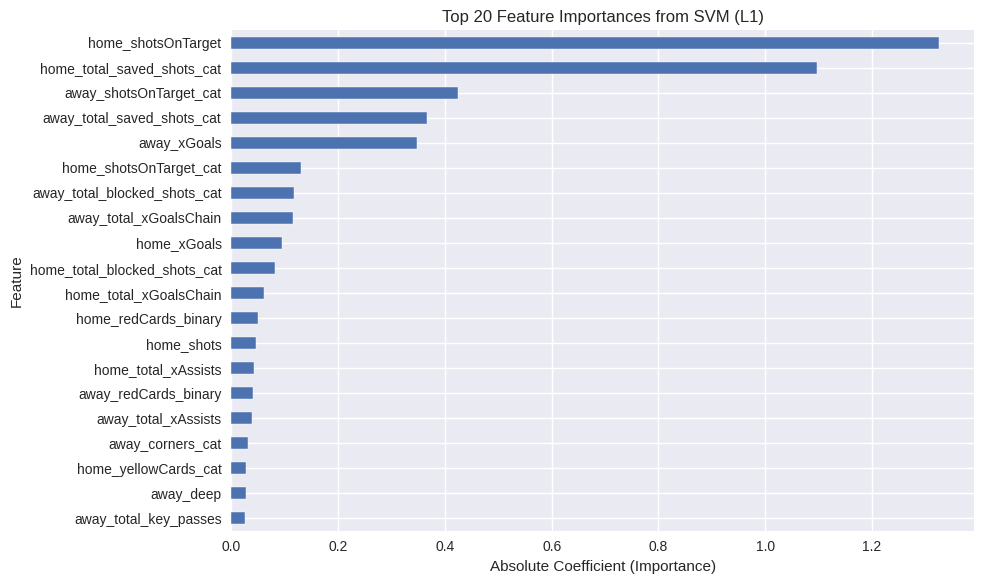

In [66]:
# Plot top 20 SVM feature importances
svm_result.head(20).plot(kind='barh', figsize=(10, 6))
plt.title("Top 20 Feature Importances from SVM (L1)")
plt.xlabel("Absolute Coefficient (Importance)")
plt.ylabel("Feature")
plt.gca().invert_yaxis()  # So highest is on top
plt.tight_layout()
plt.show()

## Summarization and Selection of Variables


In [67]:
varSel['Sum'] =  np.sum(varSel,axis=1)
varSel

,Variable,Univarable,Lasso,RandomForest,GradienBoosting,SVM,Sum
0,leagueID,0,0,0,0,1,1
1,season,1,0,0,0,1,2
2,home_xGoals,1,1,1,1,1,5
3,home_shots,1,1,0,0,1,3
4,home_shotsOnTarget,1,1,1,1,1,5
...,...,...,...,...,...,...,...
73,rolling_shot_rate_vs_blocks,0,0,0,0,0,0
74,discipline_matchup_score,0,0,0,0,0,0
75,interaction_away_goal_rate_vs_home_def,0,0,0,0,0,0
76,interaction_away_form_vs_home_cards,0,0,0,0,1,1


In [68]:

varSel.groupby('Sum')['Variable'].count()

Sum
0    19
1    26
2    14
3     6
4     5
5     8
Name: Variable, dtype: int64

In [69]:
varSel[varSel['Sum']==5]

,Variable,Univarable,Lasso,RandomForest,GradienBoosting,SVM,Sum
2,home_xGoals,1,1,1,1,1,5
4,home_shotsOnTarget,1,1,1,1,1,5
12,away_xGoals,1,1,1,1,1,5
17,away_total_xAssists,1,1,1,1,1,5
19,away_total_xGoalsChain,1,1,1,1,1,5
26,home_shotsOnTarget_cat,1,1,1,1,1,5
27,away_shotsOnTarget_cat,1,1,1,1,1,5
32,home_total_saved_shots_cat,1,1,1,1,1,5


In [70]:
varSel[varSel['Sum']==3]

,Variable,Univarable,Lasso,RandomForest,GradienBoosting,SVM,Sum
3,home_shots,1,1,0,0,1,3
22,home_redCards_binary,1,1,0,0,1,3
23,away_redCards_binary,1,1,0,0,1,3
24,home_yellowCards_cat,1,1,0,0,1,3
30,home_total_blocked_shots_cat,1,1,0,0,1,3
64,away_discipline_score_avg,1,1,0,0,1,3


In [71]:
varSel[varSel['Sum']>=3]

,Variable,Univarable,Lasso,RandomForest,GradienBoosting,SVM,Sum
2,home_xGoals,1,1,1,1,1,5
3,home_shots,1,1,0,0,1,3
4,home_shotsOnTarget,1,1,1,1,1,5
6,home_ppda,1,1,1,0,1,4
8,home_total_xAssists,1,1,1,0,1,4
10,home_total_xGoalsChain,1,0,1,1,1,4
12,away_xGoals,1,1,1,1,1,5
15,away_ppda,1,1,1,0,1,4
17,away_total_xAssists,1,1,1,1,1,5
19,away_total_xGoalsChain,1,1,1,1,1,5


In [72]:
varSel[varSel['Sum']>=2]

,Variable,Univarable,Lasso,RandomForest,GradienBoosting,SVM,Sum
1,season,1,0,0,0,1,2
2,home_xGoals,1,1,1,1,1,5
3,home_shots,1,1,0,0,1,3
4,home_shotsOnTarget,1,1,1,1,1,5
5,home_deep,1,0,0,0,1,2
6,home_ppda,1,1,1,0,1,4
7,home_fouls,1,0,0,0,1,2
8,home_total_xAssists,1,1,1,0,1,4
10,home_total_xGoalsChain,1,0,1,1,1,4
11,home_total_xGoalsBuildup,1,0,1,0,0,2


In [73]:
type(varSel)

pandas.core.frame.DataFrame

In [74]:
final_var = varSel[varSel['Sum']>=3]['Variable'].tolist()
df_model = df[final_var].copy()
## add our Y 
df_model['gameresult'] = df['gameresult'].copy()

In [75]:
df_model.shape


(12680, 20)

In [76]:
df_model.to_csv('../csvs/df_model.csv')


In [77]:
# saving df for modeling
with open("../pickles/df_model.pkl", "wb") as f:
    pickle.dump(df_model, f)  # Save the DataFrame with standard pickle

## Setting proportion for Train, Test, Dev


In [78]:
from pyMechkar.analysis import train_test

In [79]:
train, temp = train_test(df_model, prop=0.6, seed=18)

Begining analysis...
Factorizing... please wait
********************
[]
*********************
*********************
[]
------ Finished in 7.567791700363159econds -----
 
You got a perfectly balanced training and test datasets
 


In [80]:
#60%
train.shape

(7608, 21)

In [81]:
df_object_train =  train.select_dtypes(include = ['object']).columns

## Encoding Categorial Data

In [82]:
# Select all categorical columns: both object and category
cat_cols = train.select_dtypes(include=['object', 'category']).columns

# Encode all of them
from sklearn.preprocessing import OrdinalEncoder

ord_enc = OrdinalEncoder()
train[cat_cols] = ord_enc.fit_transform(train[cat_cols])

In [83]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7608 entries, 8859 to 11119
Data columns (total 21 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   home_xGoals                   7608 non-null   float64
 1   home_shots                    7608 non-null   float64
 2   home_shotsOnTarget            7608 non-null   int64  
 3   home_ppda                     7608 non-null   float64
 4   home_total_xAssists           7608 non-null   float64
 5   home_total_xGoalsChain        7608 non-null   float64
 6   away_xGoals                   7608 non-null   float64
 7   away_ppda                     7608 non-null   float64
 8   away_total_xAssists           7608 non-null   float64
 9   away_total_xGoalsChain        7608 non-null   float64
 10  home_redCards_binary          7608 non-null   bool   
 11  away_redCards_binary          7608 non-null   bool   
 12  home_yellowCards_cat          7608 non-null   float64
 13 

In [84]:
train.to_csv('../csvs/Football_Database_train.csv')

In [85]:
# saving df after finishing feature engineering
with open("../pickles/train.pkl", "wb") as f:
    pickle.dump(train, f)  # Save the DataFrame with standard pickle

In [86]:

dev, test = train_test(temp, prop=0.5, seed=18)

Begining analysis...
Factorizing... please wait
********************
[]
*********************
*********************
[]
------ Finished in 7.603627443313599econds -----
 
You got a perfectly balanced training and test datasets
 


In [87]:
# Select all categorical columns: both object and category
cat_cols_test = test.select_dtypes(include=['object', 'category']).columns

ord_enc_test = OrdinalEncoder()
test[cat_cols] = ord_enc.fit_transform(test[cat_cols])

# Select all categorical columns: both object and category
cat_cols_dev = dev.select_dtypes(include=['object', 'category']).columns

ord_enc_dev = OrdinalEncoder()
dev[cat_cols] = ord_enc.fit_transform(dev[cat_cols])

In [88]:
#50%
test.shape

(2536, 21)

In [89]:
test.to_csv('../csvs/Football_Database_test.csv')

# saving df after finishing feature engineering
with open("../pickles/test.pkl", "wb") as f:
    pickle.dump(test, f)  # Save the DataFrame with standard pickle

In [90]:
test

,home_xGoals,home_shots,home_shotsOnTarget,home_ppda,home_total_xAssists,home_total_xGoalsChain,away_xGoals,away_ppda,away_total_xAssists,away_total_xGoalsChain,...,away_redCards_binary,home_yellowCards_cat,home_shotsOnTarget_cat,away_shotsOnTarget_cat,home_total_blocked_shots_cat,home_total_saved_shots_cat,away_total_saved_shots_cat,away_discipline_score_avg,gameresult,split
9123,1.354740,10.000000,3,6.1111,1.182628,1.025618,0.484752,10.8800,0.305696,0.905245,...,False,2.0,5.0,6.0,3.0,2.0,4.0,-26.000000,2,0.0
809,1.030380,19.000000,3,2.2500,0.634875,2.760650,0.263110,12.7333,0.205247,0.577086,...,False,2.0,5.0,4.0,9.0,3.0,2.0,-27.785714,1,0.0
780,0.744526,15.000000,2,7.5758,0.541279,1.120400,1.413000,6.0476,0.865091,4.211229,...,False,5.0,4.0,5.0,6.0,2.0,2.0,-24.104167,0,0.0
265,2.074880,11.000000,5,10.8571,1.528366,5.236435,1.216380,8.1000,0.934175,1.840798,...,False,2.0,7.0,4.0,1.0,2.0,0.0,-20.793103,2,0.0
12190,1.754310,13.484856,8,3.3704,1.073796,4.081372,0.547118,23.8000,0.504012,0.899477,...,True,1.0,10.0,4.0,9.0,7.0,1.0,-20.111111,1,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4626,1.495350,16.000000,6,10.6190,0.552496,3.685556,3.363920,12.4615,2.898960,4.809696,...,False,2.0,8.0,11.0,4.0,5.0,4.0,-17.810811,0,0.0
11262,1.474980,13.000000,6,7.6000,1.323135,1.247887,1.407060,4.7647,1.253420,3.484246,...,False,2.0,8.0,6.0,3.0,5.0,2.0,-22.076923,0,0.0
3731,0.600074,8.000000,2,10.0000,0.570147,2.078904,1.517170,11.6923,0.677178,2.772529,...,False,1.0,4.0,6.0,2.0,1.0,1.0,-19.357143,0,0.0
439,0.569734,13.000000,4,10.9583,0.522914,0.855076,0.776105,9.6111,0.545509,1.371013,...,False,1.0,6.0,4.0,6.0,2.0,2.0,-23.943396,2,0.0


In [91]:
dev.to_csv('../csvs/Football_Database_dev.csv')

# saving df after finishing feature engineering
with open("../pickles/dev.pkl", "wb") as f:
    pickle.dump(dev, f)  # Save the DataFrame with standard pickle

In [92]:
dev

,home_xGoals,home_shots,home_shotsOnTarget,home_ppda,home_total_xAssists,home_total_xGoalsChain,away_xGoals,away_ppda,away_total_xAssists,away_total_xGoalsChain,...,away_redCards_binary,home_yellowCards_cat,home_shotsOnTarget_cat,away_shotsOnTarget_cat,home_total_blocked_shots_cat,home_total_saved_shots_cat,away_total_saved_shots_cat,away_discipline_score_avg,gameresult,split
10682,0.537278,11.0,4,8.2727,0.422670,1.474588,5.346760,7.3200,3.166349,9.721039,...,False,3.0,6.0,3.0,4.0,4.0,7.0,-22.828125,0,0.0
10794,1.027300,14.0,5,18.6000,0.940323,3.602186,0.716385,14.1875,0.603594,2.690534,...,False,2.0,7.0,4.0,3.0,5.0,2.0,-22.363636,1,0.0
2455,1.082450,9.0,4,9.6667,0.972738,4.311075,0.505706,6.1923,0.443530,0.459544,...,False,3.0,6.0,5.0,2.0,1.0,3.0,-23.285714,2,0.0
6463,0.106979,2.0,0,10.0000,0.082412,0.519041,1.471830,6.6190,1.396730,2.238010,...,False,4.0,0.0,8.0,0.0,0.0,7.0,-19.195652,0,0.0
168,0.973378,22.0,2,5.4706,0.720419,2.698206,0.401988,12.1515,0.246433,0.434275,...,False,0.0,4.0,4.0,9.0,2.0,2.0,-24.942857,1,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3475,1.256860,15.0,4,4.4286,1.062406,4.798060,0.234038,11.2609,0.234038,1.192164,...,True,2.0,6.0,5.0,4.0,3.0,2.0,-24.000000,1,0.0
1487,0.138495,4.0,1,6.5957,0.125602,0.304673,1.003940,2.5455,0.817040,5.563515,...,False,5.0,1.0,4.0,1.0,1.0,2.0,-23.683333,1,0.0
4070,1.424000,16.0,3,4.9200,1.139164,7.039235,1.329110,12.0000,1.329109,3.736182,...,False,4.0,5.0,4.0,9.0,2.0,0.0,-15.306452,0,0.0
4404,2.011290,7.0,4,11.8261,1.141297,5.769247,2.038150,6.8571,0.766147,2.161253,...,False,2.0,6.0,6.0,0.0,1.0,4.0,-16.700000,2,0.0


In [93]:
dev.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2536 entries, 10682 to 9411
Data columns (total 21 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   home_xGoals                   2536 non-null   float64
 1   home_shots                    2536 non-null   float64
 2   home_shotsOnTarget            2536 non-null   int64  
 3   home_ppda                     2536 non-null   float64
 4   home_total_xAssists           2536 non-null   float64
 5   home_total_xGoalsChain        2536 non-null   float64
 6   away_xGoals                   2536 non-null   float64
 7   away_ppda                     2536 non-null   float64
 8   away_total_xAssists           2536 non-null   float64
 9   away_total_xGoalsChain        2536 non-null   float64
 10  home_redCards_binary          2536 non-null   bool   
 11  away_redCards_binary          2536 non-null   bool   
 12  home_yellowCards_cat          2536 non-null   float64
 13 